# FIT3081 Image Processing - Assingment 3 (S1, 2023)

<div style="text-align: left"> <h3> Student 1: Kuah Jia Chen, 32286988  </h3>  </div>
<div style="text-align: left"> <h3> Student 2: Samuel Tai Meng Yao, 32025068  </h3>  </div>

<hr style="height:3px;border-width:0;color:gray;background-color:gray">

## Outline

1. Overview of the Process (Dataset + Segmentation + Recognition)
2. Overview (This notebook)
3. Import Libraries
4. Helper Functions
5. Section 1: Malaysian Number Plate Preprocessing & Automated Segmentation

## Overview of the Process (Dataset + Segmentation + Recognition)

We have broken the process of Malaysian Number Plate Recognition into 3 separated notebooks to make it easier for the marker to read. The 3 notebooks are on <b> dataset pre-processing </b>, <b>segmentation of Malaysian number plate</b> and <b>recognition of Malaysian number plate</b> using the trained Neural Network respectively. The notebooks can be found in the submission folder. 


## Overview (This notebook)
This notebook contains the code for automatic segmentation on the input number plate. The general process of the segmentaion is broken into 2 parts, pre-processing and segmentation. Pre-processing is to prepare the number plate for the segmentation, operations such as noise smoothing, resize and more have been performed. Whereas segmentation will be operated on the pre-processed number plate to automatically segment the characters (alphabets and numerals) then store it into the respective folders.

After the automated segmentation is done, we named the cropped images ourselves manually in the folders.

The segmented number plate will then be read by the Neural Network in another notebook to perform the recognition process and output the results.

## Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import math
import os
import numpy as np
from PIL import Image
import functools

## Helper Functions

In [2]:
def read_img(image_name):
    """
    Read image and convert to gray scale
    """
    number_plate_char = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)    # Read and convert to grayscale
    
    return np.array(number_plate_char)

In [3]:
def resize_img(img_arr, w, h):
    """
    Resize the image to the desired w x h
    """
    number_plate_char = cv2.resize(img_arr, (w,h))
    
    return number_plate_char

In [4]:
def bilateral_smoothing(img_arr, d, sigmaColor, sigmaSpace):
    """
    Noise smoothing on image using bilateral filter
    """
    bilateral = cv2.bilateralFilter(img_arr, d, sigmaColor, sigmaSpace)
    
    return bilateral

In [5]:
def pre_process_filled(img_name, w,h):
    """
    Pre-process the image(number plate) to transform it into a edged image 
    """
    img_arr = read_img(img_name)    # Read image
    img_arr = resize_img(img_arr, w, h)  # Resize the image
    smooth_img_arr = bilateral_smoothing(img_arr, 15, 150, 150)   # Noise smoothing
    
    # Using adaptive threshold to transform the image into binary image (fine-tuning) 
    adapT = cv2.adaptiveThreshold(smooth_img_arr, 255, \
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                              cv2.THRESH_BINARY, 77, 4)
    
    return adapT

In [6]:
def remove_white_blob(img_arr, width, height):
    """
    Remove the white blob within the image that is below or higher than the determined threshold
    White blob will be considered as noise or unwanted element within the image
    """
    # Perform connected components analysis on the thresholded image
    _, labels = cv2.connectedComponents(img_arr)
    
    # Initialize the mask to hold only the components we are interested in
    mask = np.zeros(img_arr.shape, dtype="uint8")
    
    # Set lower bound and upper bound criteria for characters
    total_pixels = width * height
    lower = total_pixels // 43   # Lower bound (can be fine tune)
    upper = total_pixels // 13.5 # upper bound (can be fine tune)

    
    # Loop over the unique components
    for (j, label) in enumerate(np.unique(labels)):
        # If this is the background label, ignore it
        if label == 0:
            continue

        # Otherwise, construct the label mask to display only connected component for the current label
        label_mask = np.zeros(img_arr.shape, dtype="uint8")
        label_mask[labels == label] = 255
        numPixels = cv2.countNonZero(label_mask)  # Calculate the number of pixels

        # If the number of pixels in the component is between lower bound and upper bound, 
        # add it to the mask (i.e., it is part of the characters in the number plate)
        if numPixels > lower and numPixels < upper:
            mask = cv2.add(mask, label_mask)
            
    return mask

In [7]:
def compare(rect1, rect2):
    """
    Compare the position of the rectangle
    """
    return rect1[0] - rect2[0]

## Section 1: Malaysian Number Plate Preprocessing & Automated Segmentation

In this section, we will first pre-process the number plate. Next, automatic segmentation is performed to determine and crop each character in each Malaysian number plate. The cropped characters in each number plate will then be stored into the respective folders that we have prepared with respect to the determined path. 

The results of the preprocessed Malaysian Number Plates are shown at the end of the notebook.

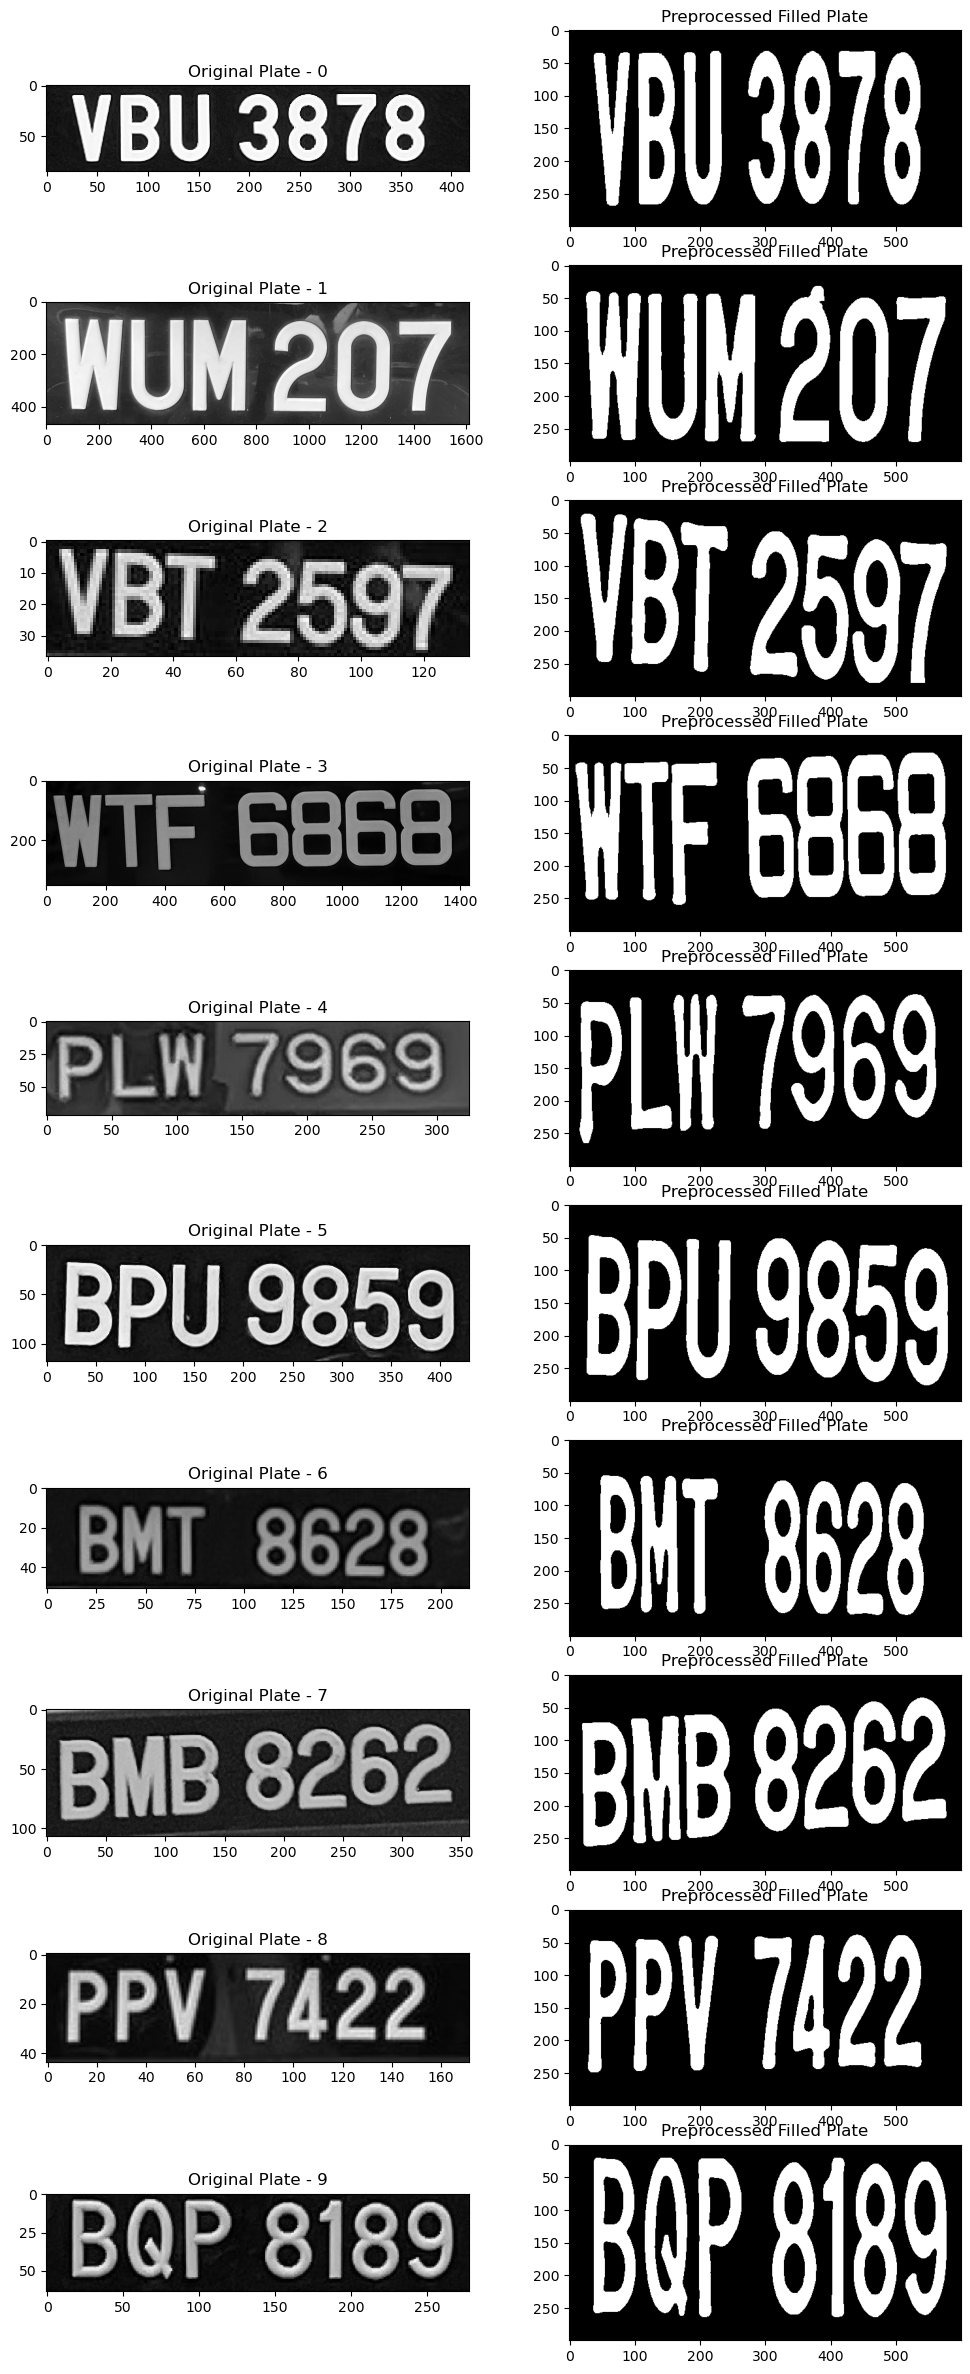

In [8]:
dir = r"C:\Users\User\Documents\Monash Y3\S1\FIT 3081\Assignment\A3\Test cases"

fig, axs = plt.subplots(len(os.listdir(dir)), 2, figsize=(12, 3*len(os.listdir(dir))))

for i, pic in enumerate(os.listdir(dir)):
    crop_num = 0
    pic_dir = os.path.join(dir,pic)
    ori_img = read_img(pic_dir)
    width, height = 600, 300
    thresh = pre_process_filled(pic_dir, width, height)        # Pre-process the number plate into filled image
    
    kernel = np.ones((4,4),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)  # Perform morphological opening operation

    # Remove white blob (that below or exceed certain threshold)
    mask = remove_white_blob(thresh, width, height)
    
    # Turn the first n pixels on at the top and down, left and right to black to remove any noise
    # Assuming characrers on the number plate would located at the middle of the image
    for k in range(len(thresh)):
        for l in range(len(thresh[i])):
            if k <= 20 or k >= (len(thresh) - 20) or l < 10 or l >= len(thresh[i]) - 10 :
                mask[k][l] = 0
            else:
                continue
                
    # Remove the white blob again (ensuring all white blob are removed)
    # Do it again due to some blob is too big and having the same number of pixels as the characters in the previous cleaning
    final_mask = remove_white_blob(mask, width, height)

    # Find contours and get bounding box for each contour
    cnts, _ = cv2.findContours(final_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(contour) for contour in cnts]
    
    # Sort the bounding boxes from left to right
    boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))

    ep = 2   # Extra padding
    
    for rect in boundingBoxes:
        x,y,w,h = rect   # Get the coordinates from the bounding box
        crop = final_mask[y-ep:y+h+ep, x-ep:x+w+ep]  # Crop the character from the mask
    
        resized_crop = resize_img(crop, 64, 64)  # Resize the cropped image
        
        # Save the cropped plate to the respective folder 
        LP_name = f'LP{i+1}'
        path = 'C:\\Users\\User\\Documents\\Monash Y3\\S1\\FIT 3081\\Assignment\\A3\\Segmentation2\\' + LP_name
        cv2.imwrite(os.path.join(path , f'crop{crop_num}.jpg'), resized_crop)
        crop_num += 1
    
    axs[i, 0].imshow(cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title(f'Original Plate - {i}')
    axs[i, 1].imshow(cv2.cvtColor(final_mask, cv2.COLOR_GRAY2RGB))
    axs[i, 1].set_title('Preprocessed Filled Plate')
